<a href="https://colab.research.google.com/github/jgromero/rl_seminar_2023/blob/main/code/iris_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with the _iris_ dataset
[**Juan Gómez Romero**](https://ccia.ugr.es/~jgomez)  
Departamento de Ciencias de la Computación e Inteligencia Artificial  
Universidad de Granada  
This work is licensed under the [GNU General Public License v3.0](https://choosealicense.com/licenses/gpl-3.0/).


---

### Activate GPU
_Runtime > Change runtime type_



In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load _iris_ data
Load [ _iris_](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) from [`scikit-learn`](https://scikit-learn.org/).
- features: input (150 x 4)
- labels: output (150 x 1)

In [ ]:
from sklearn import datasets
data = datasets.load_iris()

features = data.data[:, :]
labels   = data.target

print(data['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Visualize data with [`matplotlib`](https://matplotlib.org/). The classes in the _iris_ dataset can be easily separated by using the variables `petal_length` and `petal_width`.


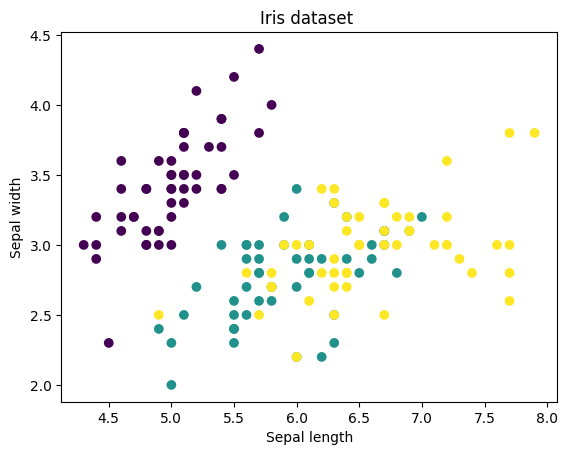

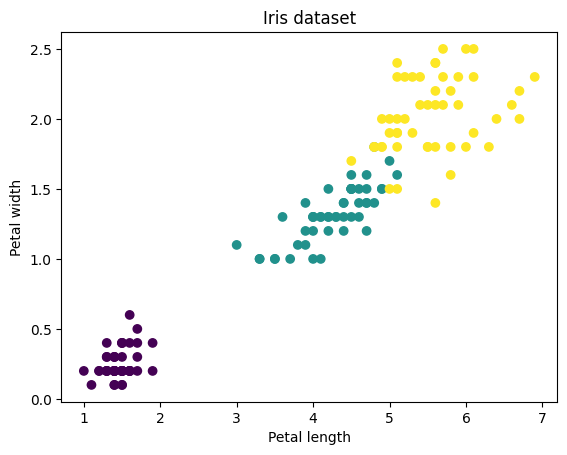

In [ ]:
import matplotlib.pyplot as plt
plt.title('Iris dataset ')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.scatter(features[:, 0], features[:, 1], c = labels)
plt.show()

plt.title('Iris dataset')
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.scatter(features[:, 2], features[:, 3], c = labels)
plt.show()

## Define network architecture
The architecture is quite simple:
- Input size: 4 neurons
- Hidden layer: 2 x 16 neurons (*sigmoid* activation)
- Output: 3 neurons (*softmax*)

<img src="https://github.com/jgromero/eci2019-DRL/blob/master/Tema%202%20-%20Aprendizaje%20Profundo/code/iris-nn.png?raw=true" width="500">

In [ ]:
import torch.nn as nn

torch.manual_seed(1)

net = nn.Sequential(
    nn.Linear(in_features = features.shape[1], out_features = 16),
    nn.ReLU(),
    nn.Linear(in_features = 16, out_features = 16),
    nn.ReLU(),
    nn.Linear(in_features = 16, out_features = 3),
    nn.Softmax(dim = 0)
)
net = net.to(device)

net

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=3, bias=True)
  (5): Softmax(dim=0)
)

Calculate output for the first instance of the training set.

In [ ]:
input = torch.tensor(features[0, :], dtype=torch.float32, device=device)
output = net(input)
print("Network output: " , output)
print("Class prediction: " , torch.argmax(output).item())
print("Expected output: ", labels[0])

Network output:  tensor([0.2294, 0.3464, 0.4241], device='cuda:0', grad_fn=<SoftmaxBackward0>)
Class prediction:  2
Expected output:  0


## Prepare data for network training
Change data formats to be used by PyTorch and split training and validation subsets.

In [ ]:
import torch.utils.data

x_dataset = torch.tensor(features, dtype = torch.float32)
y_dataset = torch.tensor(labels, dtype = torch.long)
dataset   = torch.utils.data.TensorDataset(x_dataset, y_dataset)

perc_split = 0.8
n_train = round(perc_split * len(features))
n_val   = len(features) - n_train
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])

## Train network with _train\_set_

Define loss function, optimization algorithm and other hyperparameters.

In [ ]:
import torch.optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

batch_size = 10
n_epochs   = 1000

Launch training.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

for epoch in range(n_epochs):
    epoch_loss = 0.0

    for (i, data) in enumerate(train_loader, 0):
        x, y = data

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()       # reset gradients

        y_hat = net(x)              # calculate forward output
        loss = criterion(y_hat, y)  # calculate loss
        loss.backward()             # error backpropagation
        optimizer.step()            # optimize weights

        epoch_loss += loss.item()

    if(epoch % 100 == 0):
        print("Epoch [%4d/%4d], epoch loss: %.3f" % (epoch, n_epochs, float(epoch_loss) / batch_size))

Epoch [   0/1000], epoch loss: 1.300
Epoch [ 100/1000], epoch loss: 1.193
Epoch [ 200/1000], epoch loss: 1.177
Epoch [ 300/1000], epoch loss: 1.173
Epoch [ 400/1000], epoch loss: 1.176
Epoch [ 500/1000], epoch loss: 1.171
Epoch [ 600/1000], epoch loss: 1.173
Epoch [ 700/1000], epoch loss: 1.172
Epoch [ 800/1000], epoch loss: 1.181
Epoch [ 900/1000], epoch loss: 1.161


## Validation with _val\_set_

Calculate accuracy over validation subset.

In [ ]:
val_loader = torch.utils.data.DataLoader(val_set, batch_size=100, shuffle=False)

correct = 0
total = 0

with torch.no_grad():        # do not calculate gradients, just a forward pass
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)

        y_hat = net(x)
        _, predicted = torch.max(y_hat, dim = 1)
        total = total + y.shape[0]
        correct += int((predicted == y).sum())

    print("Accuracy (validation): %.2f" % (correct / total))

Accuracy (validation): 0.83


We can change the training configuration and hyperparameters to increase our accuracy, e.g. by using:
- `torch.manual_seed`
- `batch_size`
- `n_epochs`
- `nn.CrossEntropyLoss`
- `torch.optim.SGD`

**Warning**: This implies using validation outcomes to make decisions to improve the network performance, which may be seen as a validation data leakage. In these cases, we must use a third split for evaluating the performance of the classifier, i.e., a _test_ subset.


---
## EXERCISE

Extend this code to solve a different classification problem included in the [`scikit-learn`](https://scikit-learn.org/) package. For instance, [cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html).